# MobileNet - PBC Augmented Data v2
# Conclusion: 99.17%, likely the best model on both data sets

In [1]:
import os

test_dir ="PBC Data/Test - Augmented/"
train_dir = "PBC Data/Train - Augmented/"

# Count total images in training set
count_train = sum([len(files) for r, d, files in os.walk(train_dir)])
count_test = sum([len(files) for r, d, files in os.walk(test_dir)])


In [2]:
from keras.preprocessing.image import ImageDataGenerator

train = ImageDataGenerator()
traindata = train.flow_from_directory(directory=train_dir,target_size=(224,224))
test = ImageDataGenerator()
testdata = test.flow_from_directory(directory=test_dir, target_size=(224,224), shuffle = False)

Found 28530 images belonging to 6 classes.
Found 12234 images belonging to 6 classes.


In [3]:
from tensorflow import keras
img_shape = (224, 224, 3)

model = keras.applications.MobileNet(include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=img_shape,
    pooling='max',
    classes=6, alpha=1, depth_multiplier=2,dropout=.5)

print(model.summary())

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 64)      576       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 64

In [6]:
lr, epochs =  0.0001, 20
loss = keras.losses.CategoricalCrossentropy()
trainer = keras.optimizers.RMSprop(learning_rate=lr)
steps_per_epoch = count_train//64
validation_steps = count_test//64

save_it= keras.callbacks.ModelCheckpoint(filepath='pbc_a_mobile_v2.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', options=None)

model.compile(loss=loss,optimizer=trainer,metrics=['accuracy'])
my_model = model.fit(traindata, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data = testdata, validation_steps = validation_steps, verbose=1, callbacks=save_it)

print(my_model)

Epoch 1/20
445/445 [==============================] - 3070s 7s/step - loss: 0.8000 - accuracy: 0.6937 - val_loss: 5.0529 - val_accuracy: 0.0000e+00
Epoch 2/20
445/445 [==============================] - 2880s 6s/step - loss: 0.2590 - accuracy: 0.9091 - val_loss: 0.4781 - val_accuracy: 0.8529
Epoch 3/20
445/445 [==============================] - 2768s 6s/step - loss: 0.1869 - accuracy: 0.9341 - val_loss: 0.1322 - val_accuracy: 0.9678
Epoch 4/20
445/445 [==============================] - 2934s 7s/step - loss: 0.1403 - accuracy: 0.9504 - val_loss: 0.2036 - val_accuracy: 0.9277
Epoch 5/20
445/445 [==============================] - 3117s 7s/step - loss: 0.1163 - accuracy: 0.9604 - val_loss: 0.6749 - val_accuracy: 0.8318
Epoch 6/20
445/445 [==============================] - 3224s 7s/step - loss: 0.1057 - accuracy: 0.9643 - val_loss: 0.0587 - val_accuracy: 0.9838
Epoch 7/20
445/445 [==============================] - 3095s 7s/step - loss: 0.0887 - accuracy: 0.9704 - val_loss: 0.2674 - val_accur

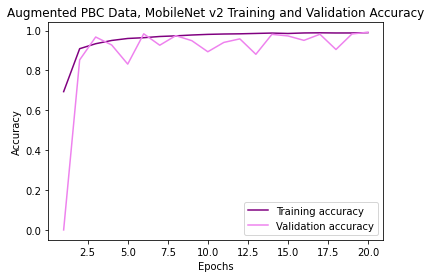

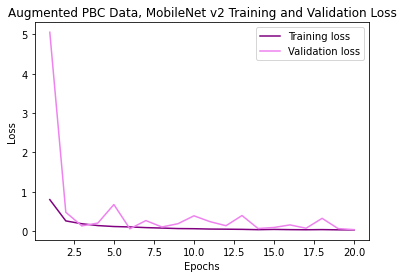

In [9]:
import utilities as u
import numpy as np

# Plot results
u.plot_results(my_model, epochs, "Augmented PBC Data, MobileNet v2")

In [11]:
# Save weights
model.save_weights('PBC Augmented Data - MobileNet v2.params')


In [12]:
# Evaluate the model on the test set
y_pred=np.argmax(model.predict(testdata), axis=-1)
classes = list(testdata.class_indices.keys())


[0 0 0 ... 5 5 0]
['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil', 'other']
[0 0 0 ... 5 5 5]


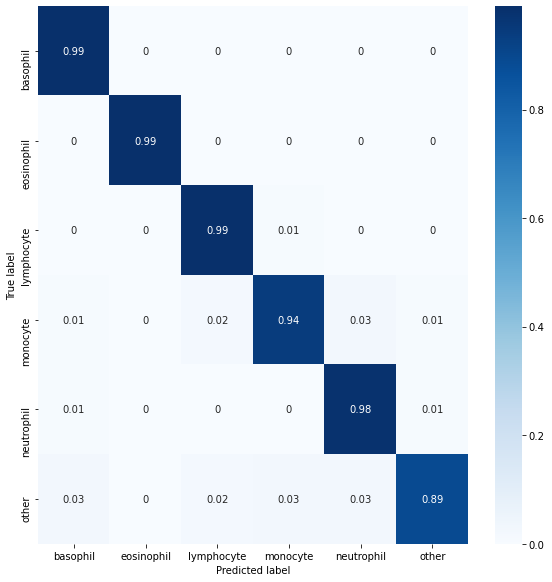

In [13]:
print(y_pred)
print(classes)
print(testdata.labels)

# Confusion Matrix
u.cm(y_pred,testdata.labels, classes)

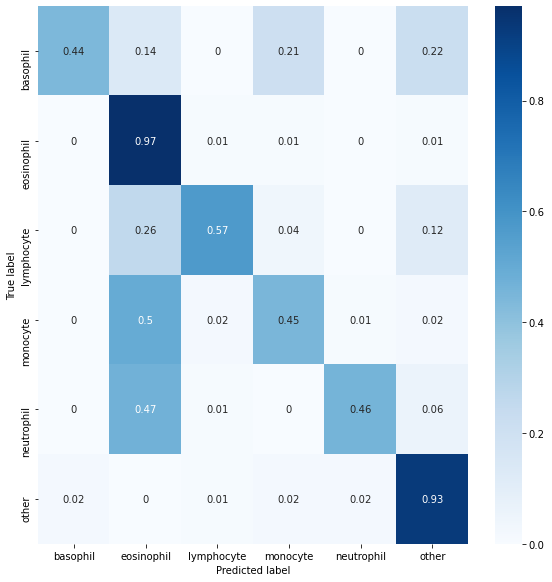

In [19]:
# What if we put all the images together? Not great, likely due to diminished clarity of images in the Rabin data set
all_dir= "All Data/"
a = ImageDataGenerator()
alldata = a.flow_from_directory(directory=all_dir, target_size=(224,224), shuffle = False)

# Evaluate the model on combined data set
yo_pred=np.argmax(model.predict(alldata), axis=-1)

# Confusion Matrix
u.cm(yo_pred,alldata.labels, classes)

Found 13300 images belonging to 5 classes.


/Users/kat/Google Drive/Study Material/PYTHON/WBC_Classifier/utilities.py:36: RuntimeWarning: invalid value encountered in true_divide
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)


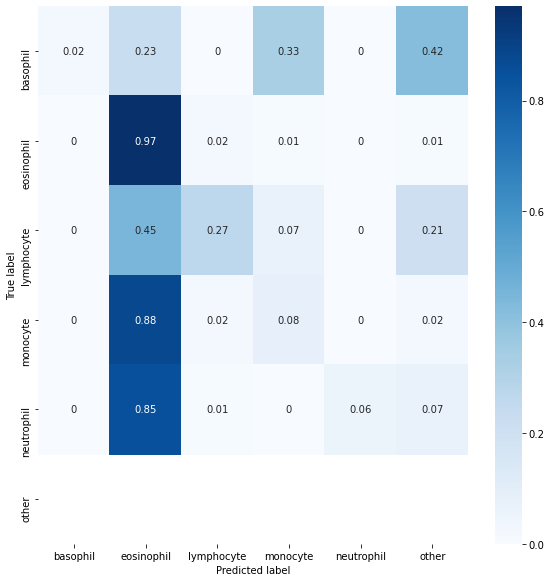

In [22]:
# What if we fit model on Rabin Test Data, Not great as these images have different resolution/sharpness
model.load_weights('PBC Augmented Data - MobileNet v2.params')
rabin_dir ="Rabin Data/Test - Augmented/"
r = ImageDataGenerator()
rabindata = r.flow_from_directory(directory=rabin_dir, target_size=(224,224), shuffle = False)

# Evaluate the model on combined data set
yr_pred=np.argmax(model.predict(rabindata), axis=-1)

# Confusion Matrix
u.cm(yr_pred,rabindata.labels, classes)

In [5]:
# To get performance metrics
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

model.load_weights('PBC Augmented Data - MobileNet v2.params')
classes = list(testdata.class_indices.keys())
y_pred=np.argmax(model.predict(testdata), axis=-1)
cnf_matrix = confusion_matrix(testdata.labels, y_pred)

In [36]:
metrics = pd.DataFrame(index =['Sensitivity', 'Specificity','Error'],
                   columns =  [x.title() for x in classes])
   
for i in range (0,len(cnf_matrix)):
    TP = cnf_matrix[i][i]
    FN = sum(cnf_matrix[i])-TP #row 
    FP = sum(cnf_matrix[:,i])-TP #col
    TN = sum(sum(cnf_matrix))-TP-FN-FP
    
    accuracy = TP/sum(cnf_matrix[i])
    error = 1-TP/sum(cnf_matrix[i])
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP) 
    
    metrics.iloc[0][i] = round(sensitivity,4)
    metrics.iloc[1][i] = round(specificity,4)
    metrics.iloc[2][i] = round(error,4)
    
print(metrics)

            Basophil Eosinophil Lymphocyte Monocyte Neutrophil   Other
Sensitivity   0.9936     0.9917     0.9897   0.9392     0.9838  0.8906
Specificity   0.9909     0.9993      0.992   0.9911     0.9877  0.9968
Error         0.0064     0.0083     0.0103   0.0608     0.0162  0.1094
